In [1]:
import numpy as np
import torch
import pandas as pd
import os
import tqdm
import sys
sys.path.append('../')
from src.metrics import evaluate_prediction
import pathlib

base = pathlib.Path("/local-scratch/samples")

def eval_results(path, n_chunks, sort_by_unsigned_rmse=True, re_eval=False):

    full_dict = dict()
    for chunk_id in range(n_chunks):
        chunk_path = path / f'chunk-{chunk_id}/results.pt'
        chunk_dict = torch.load(chunk_path)
        full_dict.update(chunk_dict)

    if re_eval:
        if not os.path.exists(path / 're_eval_results.pt'):
            results = dict()
            for generated in tqdm.tqdm(full_dict.values(), total=len(full_dict)):
                M_true = generated['mol']
                preds = generated['preds']
                M_preds = [M_true.replace(coords=pred['coords']) for pred in preds]

                log = {
                    "mol": M_true.replace(graph=None),
                    "preds": [],
                }

                for M_pred in M_preds:
                    metrics, M_aligned = evaluate_prediction(
                        M_pred=M_pred,
                        M_true=M_true,
                        return_aligned_mol=True,
                    )
                    metrics["coords"] = M_aligned.coords
                    log["preds"].append(metrics)

                results[M_true.id_as_int] = log
            
            torch.save(results, path / 're_eval_results.pt')
        else:
            results = torch.load(path / 're_eval_results.pt')
        full_dict = results

    ks = [1, 5, 10]
    metrics = ['heavy_correctness', 'correctness', 'heavy_coord_rmse', 'coord_rmse', 'unsigned_coords_rmse', 'moments_rmse']
    summary = dict()

    for k in ks:
        for metric in metrics:
            summary[f'top_{k}_{metric}'] = []

    samples = []
    for generated in full_dict.values():
        M_true = generated['mol']
        results = generated['preds']
        if sort_by_unsigned_rmse:
            unsigned_rmsds = [result['unsigned_coords_rmse'] for result in results]
            reorder_idxs = np.argsort(unsigned_rmsds)
            results = [results[i] for i in reorder_idxs]
        for metric in metrics:
            if 'correctness' in metric:
                agg = max
            elif 'rmse' in metric:
                agg = min
            for k in ks:
                summary[f'top_{k}_{metric}'].append(agg([result[metric] for result in results[:k]]))
        
        example = dict()
        example['true'] = M_true
        example['preds'] = [M_true.replace(coords=result['coords']) for result in results]
        example['correct'] = [result['correctness'] for result in results]
        example['heavy_correct'] = [result['heavy_correctness'] for result in results]
        example['id'] = M_true.id_as_int
        samples.append(example)

    df = pd.DataFrame(summary)

    avg_top_1_correctness = '%#.3g' % (df.top_1_correctness.mean() * 100)
    avg_top_5_correctness = '%#.3g' % (df.top_5_correctness.mean()* 100)

    median_top_1_rmse = '%#.3g' % (df.top_1_heavy_coord_rmse).median()
    median_top_5_rmse = '%#.3g' % (df.top_5_heavy_coord_rmse).median()

    print(f"Top 1 correctness: {avg_top_1_correctness}")
    print(f"Top 5 correctness: {avg_top_5_correctness}")
    print(f"Median Top 1 RMSD: {median_top_1_rmse}")
    print(f"Median Top 5 RMSD: {median_top_5_rmse}")

    print(f"{avg_top_1_correctness} & {avg_top_5_correctness} & {median_top_1_rmse} & {median_top_5_rmse}")

    return samples, df

In [2]:
all_df = pd.DataFrame()
all_samples = []

In [3]:
path = base / "baseline_samples/qm9/0.0"
n_chunks = 64
samples, df = eval_results(path, n_chunks, sort_by_unsigned_rmse=False, re_eval=True)
all_samples.extend(samples)
df['method'] = 'GA'
df['task'] = 'QM9'
all_df = pd.concat([all_df, df])
df.describe()

Top 1 correctness: 7.33
Top 5 correctness: 12.4
Median Top 1 RMSD: 0.842
Median Top 5 RMSD: 0.546
7.33 & 12.4 & 0.842 & 0.546


top_1_heavy_correctness  top_1_correctness  top_1_heavy_coord_rmse  \
count             13348.000000       13348.000000            13348.000000   
mean                  0.254345           0.073344                0.783733   
std                   0.435509           0.260711                0.491350   
min                   0.000000           0.000000                0.000333   
25%                   0.000000           0.000000                0.348749   
50%                   0.000000           0.000000                0.841725   
75%                   1.000000           0.000000                1.119000   
max                   1.000000           1.000000                6.949547   

       top_1_coord_rmse  top_1_unsigned_coords_rmse  top_1_moments_rmse  \
count      13348.000000                13348.000000        13348.000000   
mean           1.260242                    0.506377           15.862638   
std            0.429957                    0.288662           17.660201   
min            0.005947                    0.000184            0.010724   
25%            1.045090                    0.273335            5.192181   
50%            1.291805                    0.549824           12.259139   
75%            1.521405                    0.728615           22.864931   
max            8.933700                    1.996083         1143.044922   

       top_5_heavy_correctness  top_5_correctness  top_5_heavy_coord_rmse  \
count             13348.000000       13348.000000            13348.000000   
mean                  0.395865           0.123839                0.522920   
std                   0.489054           0.329410                0.388671   
min                   0.000000           0.000000                0.000333   
25%                   0.000000           0.000000                0.126350   
50%                   0.000000           0.000000                0.546230   
75%                   1.000000           0.000000                0.825863   
max                   1.000000           1.000000                5.783625   

       top_5_coord_rmse  top_5_unsigned_coords_rmse  top_5_moments_rmse  \
count      13348.000000                13348.000000        13348.000000   
mean           1.027899                    0.446704            9.191032   
std            0.383969                    0.285870            9.888515   
min            0.005947                    0.000184            0.010724   
25%            0.827501                    0.180268            2.869206   
50%            1.081478                    0.494284            5.839334   
75%            1.267113                    0.670434           12.634723   
max            7.736968                    1.869987          293.963715   

       top_10_heavy_correctness  top_10_correctness  top_10_heavy_coord_rmse  \
count              13348.000000        13348.000000             13348.000000   
mean                   0.463890            0.149910                 0.437814   
std                    0.498713            0.356997                 0.346741   
min                    0.000000            0.000000                 0.000333   
25%                    0.000000            0.000000                 0.103111   
50%                    0.000000            0.000000                 0.410779   
75%                    1.000000            0.000000                 0.717939   
max                    1.000000            1.000000                 5.170011   

       top_10_coord_rmse  top_10_unsigned_coords_rmse  top_10_moments_rmse  
count       13348.000000                 13348.000000         13348.000000  
mean            0.948404                     0.426544             7.204238  
std             0.367904                     0.283304             8.378249  
min             0.005947                     0.000184             0.010724  
25%             0.752912                     0.125798             2.311302  
50%             1.003200                     0.476943             4.416560  
75%    

In [4]:
path = base / "baseline_samples/qm9/0.1"
n_chunks = 64
samples, df = eval_results(path, n_chunks, sort_by_unsigned_rmse=False, re_eval=True)
all_samples.extend(samples)
df['method'] = 'GA'
df['task'] = 'QM9-C'
all_df = pd.concat([all_df, df])
df.describe()

Top 1 correctness: 0.127
Top 5 correctness: 0.225
Median Top 1 RMSD: 1.29
Median Top 5 RMSD: 1.05
0.127 & 0.225 & 1.29 & 1.05


top_1_heavy_correctness  top_1_correctness  top_1_heavy_coord_rmse  \
count             13348.000000       13348.000000            13348.000000   
mean                  0.002622           0.001274                1.302689   
std                   0.051141           0.035666                0.328958   
min                   0.000000           0.000000                0.000779   
25%                   0.000000           0.000000                1.075944   
50%                   0.000000           0.000000                1.290942   
75%                   0.000000           0.000000                1.516808   
max                   1.000000           1.000000                6.067478   

       top_1_coord_rmse  top_1_unsigned_coords_rmse  top_1_moments_rmse  \
count      13348.000000                13348.000000        13348.000000   
mean           1.591802                    0.619853           24.374372   
std            0.299794                    0.259843           15.372000   
min            0.005947                    0.000000            0.010724   
25%            1.396144                    0.417264           15.457958   
50%            1.563390                    0.646363           22.145676   
75%            1.764954                    0.804670           30.373540   
max           12.247643                    2.349962          599.374268   

       top_5_heavy_correctness  top_5_correctness  top_5_heavy_coord_rmse  \
count             13348.000000       13348.000000            13348.000000   
mean                  0.005844           0.002248                1.055959   
std                   0.076222           0.047357                0.263492   
min                   0.000000           0.000000                0.000779   
25%                   0.000000           0.000000                0.893399   
50%                   0.000000           0.000000                1.049421   
75%                   0.000000           0.000000                1.221859   
max                   1.000000           1.000000                5.805187   

       top_5_coord_rmse  top_5_unsigned_coords_rmse  top_5_moments_rmse  \
count      13348.000000                13348.000000        13348.000000   
mean           1.391127                    0.495211           14.345357   
std            0.238184                    0.246903            9.187846   
min            0.005947                    0.000000            0.010724   
25%            1.242388                    0.265096            9.137576   
50%            1.378497                    0.512312           13.160874   
75%            1.527137                    0.686707           18.275428   
max            9.845168                    1.777335          599.374268   

       top_10_heavy_correctness  top_10_correctness  top_10_heavy_coord_rmse  \
count              13348.000000        13348.000000             13348.000000   
mean                   0.009140            0.003371                 0.973563   
std                    0.095169            0.057967                 0.246417   
min                    0.000000            0.000000                 0.000779   
25%                    0.000000            0.000000                 0.821272   
50%                    0.000000            0.000000                 0.974012   
75%                    0.000000            0.000000                 1.126555   
max                    1.000000            1.000000                 5.805187   

       top_10_coord_rmse  top_10_unsigned_coords_rmse  top_10_moments_rmse  
count       13348.000000                 13348.000000         13348.000000  
mean            1.323988                     0.457327            11.717326  
std             0.218242                     0.240017             7.024003  
min             0.005947                     0.000000             0.010724  
25%             1.187471                     0.229608             7.379754  
50%             1.317211                     0.471485            10.716409  
75%    

In [5]:
path = base / "baseline_samples/geom/0.0"
n_chunks = 128
samples, df = eval_results(path, n_chunks, sort_by_unsigned_rmse=False, re_eval=True)
all_samples.extend(samples)
df['method'] = 'GA'
df['task'] = 'GEOM'
all_df = pd.concat([all_df, df])
df.describe()

Top 1 correctness: 0.0308
Top 5 correctness: 0.0377
Median Top 1 RMSD: 2.05
Median Top 5 RMSD: 1.77
0.0308 & 0.0377 & 2.05 & 1.77


top_1_heavy_correctness  top_1_correctness  top_1_heavy_coord_rmse  \
count             29204.000000       29204.000000            29204.000000   
mean                  0.001575           0.000308                2.073307   
std                   0.039657           0.017553                0.460282   
min                   0.000000           0.000000                0.002161   
25%                   0.000000           0.000000                1.790340   
50%                   0.000000           0.000000                2.045813   
75%                   0.000000           0.000000                2.328424   
max                   1.000000           1.000000                4.916590   

       top_1_coord_rmse  top_1_unsigned_coords_rmse  top_1_moments_rmse  \
count      29204.000000                29204.000000        29204.000000   
mean           2.310230                    1.348825          137.195208   
std            0.404241                    0.353637          154.525752   
min            0.077021                    0.001248            0.025955   
25%            2.044843                    1.156852           64.900829   
50%            2.257793                    1.360926          106.660538   
75%            2.519078                    1.564499          166.387623   
max            4.779873                    3.197005         5478.815430   

       top_5_heavy_correctness  top_5_correctness  top_5_heavy_coord_rmse  \
count             29204.000000       29204.000000            29204.000000   
mean                  0.002534           0.000377                1.769198   
std                   0.050275           0.019404                0.379845   
min                   0.000000           0.000000                0.002161   
25%                   0.000000           0.000000                1.545520   
50%                   0.000000           0.000000                1.769622   
75%                   0.000000           0.000000                1.993165   
max                   1.000000           1.000000                3.822250   

       top_5_coord_rmse  top_5_unsigned_coords_rmse  top_5_moments_rmse  \
count      29204.000000                29204.000000        29204.000000   
mean           2.056263                    1.271839           69.052873   
std            0.310364                    0.349466           56.595669   
min            0.077021                    0.001248            0.025955   
25%            1.860805                    1.090611           33.271778   
50%            2.036126                    1.290569           55.135015   
75%            2.225593                    1.486930           88.582027   
max            4.295289                    2.837786         1791.108398   

       top_10_heavy_correctness  top_10_correctness  top_10_heavy_coord_rmse  \
count              29204.000000        29204.000000             29204.000000   
mean                   0.003184            0.000377                 1.674690   
std                    0.056342            0.019404                 0.359534   
min                    0.000000            0.000000                 0.002161   
25%                    0.000000            0.000000                 1.467519   
50%                    0.000000            0.000000                 1.679836   
75%                    0.000000            0.000000                 1.892199   
max                    1.000000            1.000000                 3.709263   

       top_10_coord_rmse  top_10_unsigned_coords_rmse  top_10_moments_rmse  
count       29204.000000                 29204.000000         29204.000000  
mean            1.978277                     1.246894            52.000143  
std             0.287966                     0.348063            40.718087  
min             0.070938                     0.001248             0.025955  
25%             1.799019                     1.067992            26.017495  
50%             1.963299                     1.267313            41.942778  
75%    

In [6]:
path = base / "baseline_samples/geom/0.1"
n_chunks = 128
samples, df = eval_results(path, n_chunks, sort_by_unsigned_rmse=False, re_eval=True)
all_samples.extend(samples)
df['method'] = 'GA'
df['task'] = 'GEOM-C'
all_df = pd.concat([all_df, df])
df.describe()

Top 1 correctness: 0.00342
Top 5 correctness: 0.00685
Median Top 1 RMSD: 2.31
Median Top 5 RMSD: 2.08
0.00342 & 0.00685 & 2.31 & 2.08


top_1_heavy_correctness  top_1_correctness  top_1_heavy_coord_rmse  \
count             29204.000000       29204.000000            29204.000000   
mean                  0.000034           0.000034                2.348218   
std                   0.005852           0.005852                0.442187   
min                   0.000000           0.000000                0.002161   
25%                   0.000000           0.000000                2.055072   
50%                   0.000000           0.000000                2.307256   
75%                   0.000000           0.000000                2.597407   
max                   1.000000           1.000000                5.406757   

       top_1_coord_rmse  top_1_unsigned_coords_rmse  top_1_moments_rmse  \
count      29204.000000                29204.000000        29204.000000   
mean           2.473925                    1.470114          170.016091   
std            0.414956                    0.420025          156.280673   
min            0.105583                    0.000000            0.025955   
25%            2.190474                    1.237391           90.377819   
50%            2.416336                    1.460335          137.830711   
75%            2.694382                    1.706120          205.970993   
max            5.500904                    4.749074         8571.065430   

       top_5_heavy_correctness  top_5_correctness  top_5_heavy_coord_rmse  \
count             29204.000000       29204.000000            29204.000000   
mean                  0.000068           0.000068                2.107909   
std                   0.008275           0.008275                0.382088   
min                   0.000000           0.000000                0.002161   
25%                   0.000000           0.000000                1.862269   
50%                   0.000000           0.000000                2.079040   
75%                   0.000000           0.000000                2.324187   
max                   1.000000           1.000000                5.119811   

       top_5_coord_rmse  top_5_unsigned_coords_rmse  top_5_moments_rmse  \
count      29204.000000                29204.000000        29204.000000   
mean           2.255476                    1.334221          113.228669   
std            0.336745                    0.389414          106.980225   
min            0.105583                    0.000000            0.025955   
25%            2.030754                    1.136065           59.134611   
50%            2.218624                    1.345998           91.497902   
75%            2.436243                    1.562010          138.914471   
max            4.481909                    3.524084         4781.996094   

       top_10_heavy_correctness  top_10_correctness  top_10_heavy_coord_rmse  \
count              29204.000000        29204.000000             29204.000000   
mean                   0.000103            0.000068                 2.032159   
std                    0.010135            0.008275                 0.364889   
min                    0.000000            0.000000                 0.002161   
25%                    0.000000            0.000000                 1.798865   
50%                    0.000000            0.000000                 2.010829   
75%                    0.000000            0.000000                 2.239595   
max                    1.000000            1.000000                 5.119811   

       top_10_coord_rmse  top_10_unsigned_coords_rmse  top_10_moments_rmse  
count       29204.000000                 29204.000000         29204.000000  
mean            2.190976                     1.295395            98.657302  
std             0.318040                     0.382919            98.236189  
min             0.105583                     0.000000             0.025955  
25%             1.982300                     1.102193            49.995851  
50%             2.157947                     1.309593            78.565613  
75%    

In [7]:
path = base / "qm9_samples/0.0"
n_chunks = 1
samples, df = eval_results(path, n_chunks, sort_by_unsigned_rmse=True, re_eval=False)
all_samples.extend(samples)
df['method'] = 'DDPM'
df['task'] = 'QM9'
all_df = pd.concat([all_df, df])
df.describe()

Top 1 correctness: 99.9
Top 5 correctness: 99.9
Median Top 1 RMSD: 0.00626
Median Top 5 RMSD: 0.00625
99.9 & 99.9 & 0.00626 & 0.00625


top_1_heavy_correctness  top_1_correctness  top_1_heavy_coord_rmse  \
count             13348.000000       13348.000000            13348.000000   
mean                  0.999401           0.998577                0.009470   
std                   0.024475           0.037703                0.164692   
min                   0.000000           0.000000                0.002600   
25%                   1.000000           1.000000                0.005433   
50%                   1.000000           1.000000                0.006258   
75%                   1.000000           1.000000                0.007387   
max                   1.000000           1.000000               18.753372   

       top_1_coord_rmse  top_1_unsigned_coords_rmse  top_1_moments_rmse  \
count      13348.000000                13348.000000        13348.000000   
mean           0.022589                    0.005069            2.754332   
std            0.218800                    0.100133          270.317888   
min            0.003303                    0.001494            0.001985   
25%            0.009912                    0.003122            0.233887   
50%            0.012810                    0.003596            0.361879   
75%            0.017963                    0.004240            0.527541   
max           24.534678                   11.546944        31231.179688   

       top_5_heavy_correctness  top_5_correctness  top_5_heavy_coord_rmse  \
count             13348.000000       13348.000000            13348.000000   
mean                  0.999550           0.999026                0.009099   
std                   0.021198           0.031194                0.164072   
min                   0.000000           0.000000                0.002600   
25%                   1.000000           1.000000                0.005431   
50%                   1.000000           1.000000                0.006249   
75%                   1.000000           1.000000                0.007372   
max                   1.000000           1.000000               18.753372   

       top_5_coord_rmse  top_5_unsigned_coords_rmse  top_5_moments_rmse  \
count      13348.000000                13348.000000        13348.000000   
mean           0.016842                    0.005069            2.572552   
std            0.216013                    0.100133          270.319352   
min            0.003303                    0.001494            0.001985   
25%            0.008936                    0.003122            0.140027   
50%            0.010924                    0.003596            0.206095   
75%            0.014118                    0.004240            0.290579   
max           24.534678                   11.546944        31231.179688   

       top_10_heavy_correctness  top_10_correctness  top_10_heavy_coord_rmse  \
count              13348.000000        13348.000000             13348.000000   
mean                   0.999625            0.999026                 0.008956   
std                    0.019351            0.031194                 0.163568   
min                    0.000000            0.000000                 0.002600   
25%                    1.000000            1.000000                 0.005431   
50%                    1.000000            1.000000                 0.006248   
75%                    1.000000            1.000000                 0.007371   
max                    1.000000            1.000000                18.753372   

       top_10_coord_rmse  top_10_unsigned_coords_rmse  top_10_moments_rmse  
count       13348.000000                 13348.000000         13348.000000  
mean            0.016253                     0.005069             2.537050  
std             0.215458                     0.100133           270.319649  
min             0.003303                     0.001494             0.001985  
25%             0.008876                     0.003122             0.119608  
50%             0.010801                     0.003596             0.175324  
75%    

In [8]:
path = base / "qm9_samples/0.1"
n_chunks = 1
samples, df = eval_results(path, n_chunks, sort_by_unsigned_rmse=True, re_eval=False)
all_samples.extend(samples)
df['method'] = 'DDPM'
df['task'] = 'QM9-C'
all_df = pd.concat([all_df, df])
df.describe()

Top 1 correctness: 91.3
Top 5 correctness: 93.1
Median Top 1 RMSD: 0.00935
Median Top 5 RMSD: 0.00882
91.3 & 93.1 & 0.00935 & 0.00882


top_1_heavy_correctness  top_1_correctness  top_1_heavy_coord_rmse  \
count             13348.000000       13348.000000            13348.000000   
mean                  0.925981           0.912571                0.109787   
std                   0.261811           0.282473                0.413219   
min                   0.000000           0.000000                0.003039   
25%                   1.000000           1.000000                0.007052   
50%                   1.000000           1.000000                0.009353   
75%                   1.000000           1.000000                0.014944   
max                   1.000000           1.000000               27.733606   

       top_1_coord_rmse  top_1_unsigned_coords_rmse  top_1_moments_rmse  \
count      13348.000000                13348.000000        13348.000000   
mean           0.145125                    0.008850            6.522089   
std            0.488771                    0.145461          648.629747   
min            0.003326                    0.000000            0.014641   
25%            0.012080                    0.003556            0.318122   
50%            0.017078                    0.004410            0.524407   
75%            0.029318                    0.006129            0.865534   
max           37.250416                   16.751249        74939.171875   

       top_5_heavy_correctness  top_5_correctness  top_5_heavy_coord_rmse  \
count             13348.000000       13348.000000            13348.000000   
mean                  0.947633           0.931375                0.071745   
std                   0.222775           0.252824                0.335283   
min                   0.000000           0.000000                0.003039   
25%                   1.000000           1.000000                0.006812   
50%                   1.000000           1.000000                0.008815   
75%                   1.000000           1.000000                0.013436   
max                   1.000000           1.000000               27.733606   

       top_5_coord_rmse  top_5_unsigned_coords_rmse  top_5_moments_rmse  \
count      13348.000000                13348.000000        13348.000000   
mean           0.103397                    0.008850            6.145099   
std            0.428508                    0.145461          648.631592   
min            0.003326                    0.000000            0.008603   
25%            0.010907                    0.003556            0.190675   
50%            0.014919                    0.004410            0.300470   
75%            0.023679                    0.006129            0.504634   
max           37.250416                   16.751249        74939.171875   

       top_10_heavy_correctness  top_10_correctness  top_10_heavy_coord_rmse  \
count              13348.000000        13348.000000             13348.000000   
mean                   0.957522            0.938493                 0.059602   
std                    0.201685            0.240268                 0.308962   
min                    0.000000            0.000000                 0.003039   
25%                    1.000000            1.000000                 0.006811   
50%                    1.000000            1.000000                 0.008811   
75%                    1.000000            1.000000                 0.013412   
max                    1.000000            1.000000                27.733606   

       top_10_coord_rmse  top_10_unsigned_coords_rmse  top_10_moments_rmse  
count       13348.000000                 13348.000000         13348.000000  
mean            0.094149                     0.008850             6.086144  
std             0.410699                     0.145461           648.631919  
min             0.003326                     0.000000             0.008603  
25%             0.010852                     0.003556             0.170383  
50%             0.014849                     0.004410             0.273174  
75%    

In [9]:
path = base / "geom_samples/0.0"
n_chunks = 8
samples, df = eval_results(path, n_chunks, sort_by_unsigned_rmse=True, re_eval=False)
all_samples.extend(samples)
df['method'] = 'DDPM'
df['task'] = 'GEOM'
all_df = pd.concat([all_df, df])
df.describe()

Top 1 correctness: 98.9
Top 5 correctness: 99.2
Median Top 1 RMSD: 0.00617
Median Top 5 RMSD: 0.00616
98.9 & 99.2 & 0.00617 & 0.00616


top_1_heavy_correctness  top_1_correctness  top_1_heavy_coord_rmse  \
count             29204.000000       29204.000000            29204.000000   
mean                  0.994110           0.988906                0.020533   
std                   0.076519           0.104746                0.608921   
min                   0.000000           0.000000                0.003419   
25%                   1.000000           1.000000                0.005685   
50%                   1.000000           1.000000                0.006173   
75%                   1.000000           1.000000                0.006902   
max                   1.000000           1.000000              102.124596   

       top_1_coord_rmse  top_1_unsigned_coords_rmse  top_1_moments_rmse  \
count      29204.000000                29204.000000        2.920400e+04   
mean           0.073701                    0.006362        6.062099e+01   
std            5.598159                    0.345371        9.867802e+03   
min            0.005238                    0.001974        2.430177e-02   
25%            0.009530                    0.003257        1.078720e+00   
50%            0.012783                    0.003519        1.772608e+00   
75%            0.023074                    0.003877        2.794095e+00   
max          956.445007                   58.961662        1.686296e+06   

       top_5_heavy_correctness  top_5_correctness  top_5_heavy_coord_rmse  \
count             29204.000000       29204.000000            29204.000000   
mean                  0.995172           0.991611                0.016908   
std                   0.069318           0.091209                0.604592   
min                   0.000000           0.000000                0.003419   
25%                   1.000000           1.000000                0.005682   
50%                   1.000000           1.000000                0.006163   
75%                   1.000000           1.000000                0.006866   
max                   1.000000           1.000000              102.124596   

       top_5_coord_rmse  top_5_unsigned_coords_rmse  top_5_moments_rmse  \
count      29204.000000                29204.000000        2.920400e+04   
mean           0.055444                    0.006362        5.967474e+01   
std            5.279381                    0.345371        9.867805e+03   
min            0.005238                    0.001974        8.458732e-03   
25%            0.008625                    0.003257        7.028970e-01   
50%            0.010458                    0.003519        1.134649e+00   
75%            0.014672                    0.003877        1.785334e+00   
max          902.051147                   58.961662        1.686296e+06   

       top_10_heavy_correctness  top_10_correctness  top_10_heavy_coord_rmse  \
count              29204.000000        29204.000000             29204.000000   
mean                   0.995206            0.991885                 0.016345   
std                    0.069073            0.089720                 0.603646   
min                    0.000000            0.000000                 0.003419   
25%                    1.000000            1.000000                 0.005682   
50%                    1.000000            1.000000                 0.006163   
75%                    1.000000            1.000000                 0.006866   
max                    1.000000            1.000000               102.124596   

       top_10_coord_rmse  top_10_unsigned_coords_rmse  top_10_moments_rmse  
count       29204.000000                 29204.000000         2.920400e+04  
mean            0.054020                     0.006362         5.954864e+01  
std             5.279299                     0.345371         9.867806e+03  
min             0.005238                     0.001974         7.339412e-03  
25%             0.008585                     0.003257         6.424150e-01  
50%             0.010312                     0.003519         1.040537e+00  
75%    

In [10]:
path = base / "geom_samples/0.1"
n_chunks = 8
samples, df = eval_results(path, n_chunks, sort_by_unsigned_rmse=True, re_eval=False)
all_samples.extend(samples)
df['method'] = 'DDPM'
df['task'] = 'GEOM-C'
all_df = pd.concat([all_df, df])
df.describe()

Top 1 correctness: 32.6
Top 5 correctness: 35.8
Median Top 1 RMSD: 1.17
Median Top 5 RMSD: 0.765
32.6 & 35.8 & 1.17 & 0.765


top_1_heavy_correctness  top_1_correctness  top_1_heavy_coord_rmse  \
count             29204.000000       29204.000000            29204.000000   
mean                  0.370086           0.325914                1.071842   
std                   0.482836           0.468723                2.158071   
min                   0.000000           0.000000                0.004657   
25%                   0.000000           0.000000                0.026164   
50%                   0.000000           0.000000                1.166240   
75%                   1.000000           1.000000                1.841992   
max                   1.000000           1.000000              336.062500   

       top_1_coord_rmse  top_1_unsigned_coords_rmse  top_1_moments_rmse  \
count      29204.000000                29204.000000        2.920400e+04   
mean           1.175297                    0.031577        2.458033e+02   
std            9.164543                    0.032346        3.316741e+04   
min            0.005849                    0.000000        7.094880e-02   
25%            0.062942                    0.006715        4.253676e+00   
50%            1.225606                    0.025490        2.364758e+01   
75%            1.874171                    0.045663        7.557169e+01   
max         1559.982910                    1.476724        5.668073e+06   

       top_5_heavy_correctness  top_5_correctness  top_5_heavy_coord_rmse  \
count             29204.000000       29204.000000            29204.000000   
mean                  0.416176           0.358273                0.793701   
std                   0.492932           0.479501                0.906419   
min                   0.000000           0.000000                0.004657   
25%                   0.000000           0.000000                0.023632   
50%                   0.000000           0.000000                0.764954   
75%                   1.000000           1.000000                1.420721   
max                   1.000000           1.000000               94.731438   

       top_5_coord_rmse  top_5_unsigned_coords_rmse  top_5_moments_rmse  \
count      29204.000000                29204.000000        29204.000000   
mean           0.904518                    0.031577           50.343627   
std            3.400730                    0.032346         4604.740747   
min            0.005849                    0.000000            0.070949   
25%            0.044488                    0.006715            3.215357   
50%            0.920534                    0.025490           13.541041   
75%            1.503844                    0.045663           35.486895   
max          568.794678                    1.476724       786916.812500   

       top_10_heavy_correctness  top_10_correctness  top_10_heavy_coord_rmse  \
count              29204.000000        29204.000000             29204.000000   
mean                   0.429222            0.370189                 0.727100   
std                    0.494974            0.482863                 0.862454   
min                    0.000000            0.000000                 0.004657   
25%                    0.000000            0.000000                 0.023606   
50%                    0.000000            0.000000                 0.692768   
75%                    1.000000            1.000000                 1.296561   
max                    1.000000            1.000000                94.731438   

       top_10_coord_rmse  top_10_unsigned_coords_rmse  top_10_moments_rmse  
count       29204.000000                 29204.000000         29204.000000  
mean            0.848537                     0.031577            45.378924  
std             3.391350                     0.032346          4604.733908  
min             0.005849                     0.000000             0.047844  
25%             0.044073                     0.006715             3.111557  
50%             0.861835                     0.025490            11.658809  
75%    

In [ ]:
n_atoms = []
n_heavy_atoms = []
n_constrained_coords = []
n_unconstrained_coords = []
n_unconstrained_heavy_coords = []

for sample in all_samples:
    M = sample['true']
    n_atoms.append(M.coords.shape[0])
    n_heavy_atoms.append((M.atom_nums != 1).sum().item())
    n_constrained_coords.append(M.cond_mask.sum().item())
    n_unconstrained_coords.append((~M.cond_mask).sum().item())
    n_unconstrained_heavy_coords.append((~M.cond_mask[(M.atom_nums != 1).squeeze(-1)]).sum().item())

all_df['n_atoms'] = n_atoms
all_df['n_heavy_atoms'] = n_heavy_atoms
all_df['n_constrained_coords'] = n_constrained_coords
all_df['n_unconstrained_coords'] = n_unconstrained_coords
all_df['n_unconstrained_heavy_coords'] = n_unconstrained_heavy_coords

In [ ]:
all_df.to_csv('all_sample_metrics.csv')

In [4]:
all_df = pd.read_csv('all_sample_metrics.csv', index_col=0)

In [5]:
all_df[(all_df.task == 'GEOM-C') & (all_df.method == 'DDPM')].describe()

top_1_heavy_correctness  top_1_correctness  top_1_heavy_coord_rmse  \
count             29204.000000       29204.000000            29204.000000   
mean                  0.370086           0.325914                1.071842   
std                   0.482836           0.468723                2.158071   
min                   0.000000           0.000000                0.004657   
25%                   0.000000           0.000000                0.026164   
50%                   0.000000           0.000000                1.166240   
75%                   1.000000           1.000000                1.841992   
max                   1.000000           1.000000              336.062500   

       top_1_coord_rmse  top_1_unsigned_coords_rmse  top_1_moments_rmse  \
count      29204.000000                29204.000000        2.920400e+04   
mean           1.175297                    0.031577        2.458033e+02   
std            9.164543                    0.032346        3.316741e+04   
min            0.005849                    0.000000        7.094880e-02   
25%            0.062942                    0.006715        4.253676e+00   
50%            1.225606                    0.025490        2.364758e+01   
75%            1.874171                    0.045663        7.557169e+01   
max         1559.982910                    1.476724        5.668073e+06   

       top_5_heavy_correctness  top_5_correctness  top_5_heavy_coord_rmse  \
count             29204.000000       29204.000000            29204.000000   
mean                  0.416176           0.358273                0.793701   
std                   0.492932           0.479501                0.906419   
min                   0.000000           0.000000                0.004657   
25%                   0.000000           0.000000                0.023632   
50%                   0.000000           0.000000                0.764954   
75%                   1.000000           1.000000                1.420721   
max                   1.000000           1.000000               94.731438   

       top_5_coord_rmse  ...  top_10_correctness  top_10_heavy_coord_rmse  \
count      29204.000000  ...        29204.000000             29204.000000   
mean           0.904518  ...            0.370189                 0.727100   
std            3.400730  ...            0.482863                 0.862454   
min            0.005849  ...            0.000000                 0.004657   
25%            0.044488  ...            0.000000                 0.023606   
50%            0.920534  ...            0.000000                 0.692768   
75%            1.503844  ...            1.000000                 1.296561   
max          568.794678  ...            1.000000                94.731438   

       top_10_coord_rmse  top_10_unsigned_coords_rmse  top_10_moments_rmse  \
count       29204.000000                 29204.000000         29204.000000   
mean            0.848537                     0.031577            45.378924   
std             3.391350                     0.032346          4604.733908   
min             0.005849                     0.000000             0.047844   
25%             0.044073                     0.006715             3.111557   
50%             0.861835                     0.025490            11.658809   
75%             1.394391                     0.045663            27.909776   
max           568.794678                     1.476724        786916.812500   

            n_atoms  n_heavy_atoms  n_constrained_coords  \
count  29204.000000   29204.000000          29204.000000   
mean      44.205588      24.829304             48.673538   
std       10.967444       5.530396             12.296653   
min        4.000000       1.000000              0.000000   
25%       36.000000      21.000000             40.000000   
50%       44.000000      25.000000             48.000000   
75%       51.000000      28.000000             57.000000   
max      152.000000      77.000000            149.000000   

     

In [6]:
all_df[(all_df.task == 'GEOM-C') & (all_df.method == 'DDPM')].n_unconstrained_heavy_coords.mean()

25.814374743185866

In [7]:
all_df[(all_df.task == 'QM9-C') & (all_df.method == 'DDPM')].n_unconstrained_heavy_coords.mean()

9.309109979023075

In [8]:
all_df[(all_df.task == 'QM9') & (all_df.method == 'DDPM')].n_unconstrained_heavy_coords.mean()

0.08922685046448907

In [9]:
all_df[(all_df.task == 'GEOM') & (all_df.method == 'DDPM')].n_unconstrained_heavy_coords.mean()

0.6908300232844816

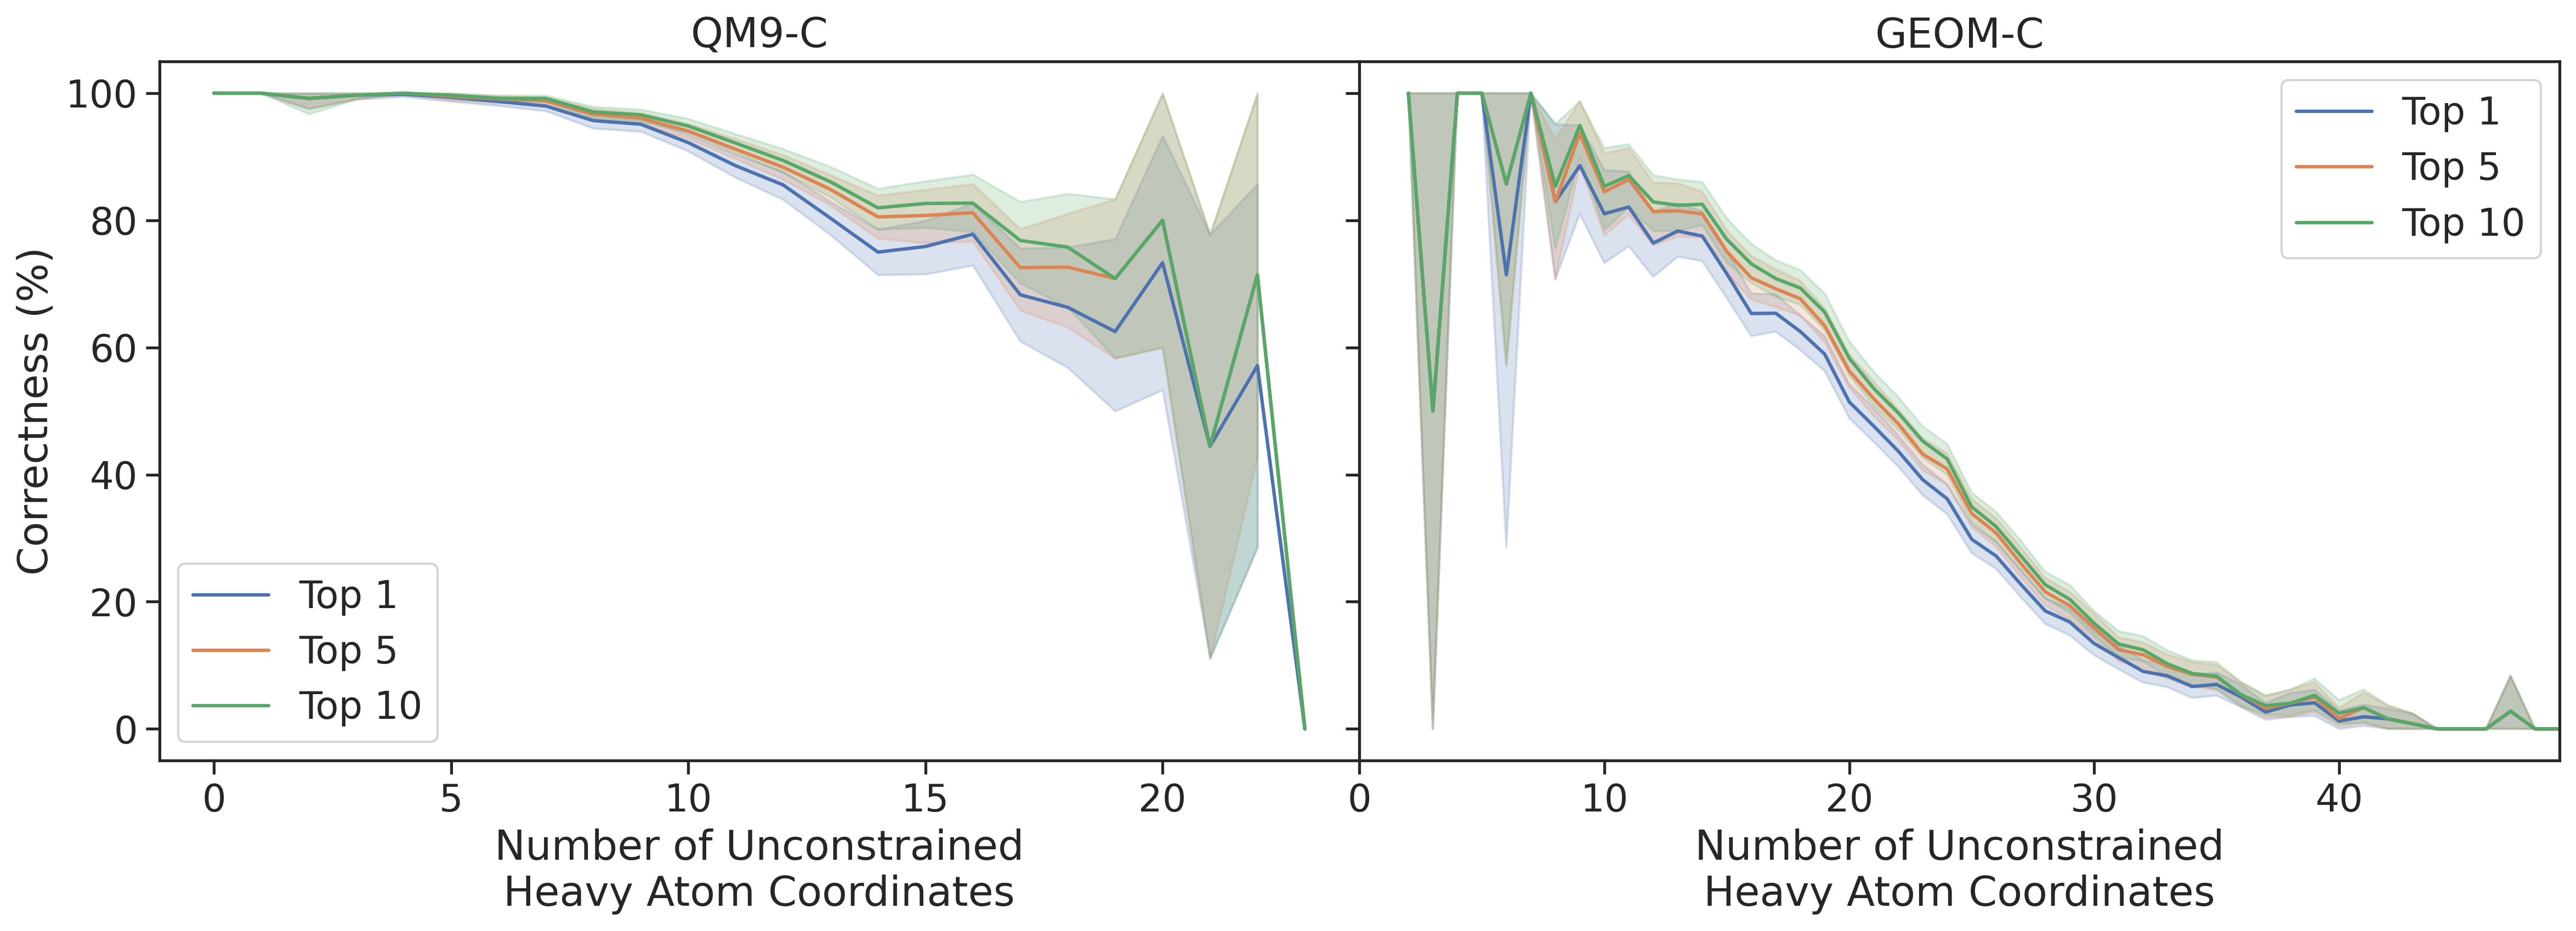

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# style = sns.axes_style("whitegrid")

# style['xtick.bottom'] = True
# style['ytick.left'] = True
# sns.set(style)
sns.set(style="ticks", font_scale=1.5)

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True, dpi=300)
axs = axs.flatten()

keep = ['n_atoms', 'n_heavy_atoms', 'n_constrained_coords', 'n_unconstrained_coords', 'n_unconstrained_heavy_coords']
topk = ['Top 1', 'Top 5', 'Top 10']
rename = {
    'top_1_correctness': 'Top 1',
    'top_5_correctness': 'Top 5',
    'top_10_correctness': 'Top 10',
}
ylabel = 'Correctness (%)'


df = all_df[(all_df.task == 'QM9-C') & (all_df.method == 'DDPM')].copy()
df = df.rename(columns=rename)
df = pd.melt(df, id_vars=keep, value_vars=topk, var_name='top_k_correctness', value_name=ylabel)
df[ylabel] = df[ylabel] * 100

g = sns.lineplot(data=df, x='n_unconstrained_heavy_coords', y=ylabel, hue='top_k_correctness', ax=axs[0],
                 # palette=c,
                 )
g.set(xlabel='Number of Unconstrained\nHeavy Atom Coordinates')
leg = axs[0].get_legend()
leg.set_title(None)
g.set(title='QM9-C')


df = all_df[(all_df.task == 'GEOM-C') & (all_df.method == 'DDPM')].copy()
df = df.rename(columns=rename)
df = pd.melt(df, id_vars=keep, value_vars=topk, var_name='top_k_correctness', value_name=ylabel)
df[ylabel] = df[ylabel] * 100

g = sns.lineplot(data=df, x='n_unconstrained_heavy_coords', y=ylabel, hue='top_k_correctness', ax=axs[1],
                 # palette=c,
                 )

g.set(xlim=(0, 49))
leg = axs[1].get_legend()
leg.set_title(None)
g.set(xlabel='Number of Unconstrained\nHeavy Atom Coordinates')
g.set(title='GEOM-C')

plt.tight_layout()
plt.subplots_adjust(wspace=0)

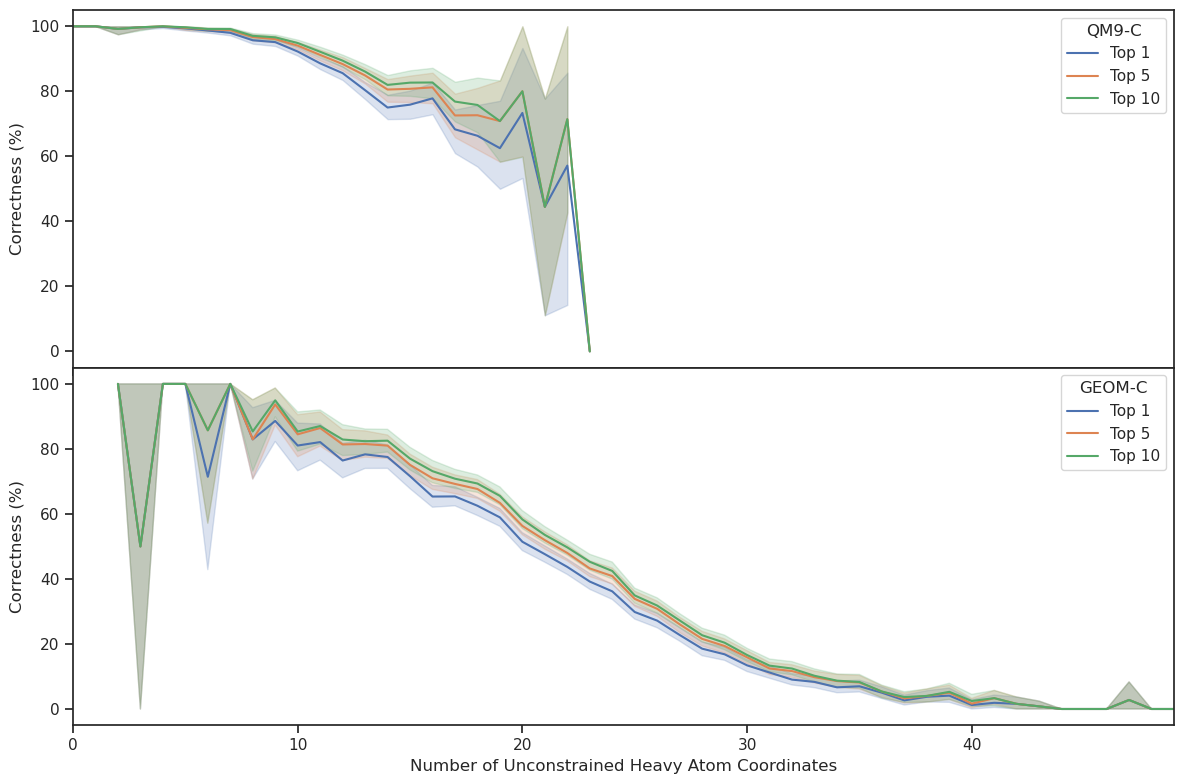

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axs = axs.flatten()

keep = ['n_atoms', 'n_heavy_atoms', 'n_constrained_coords', 'n_unconstrained_coords', 'n_unconstrained_heavy_coords']
topk = ['Top 1', 'Top 5', 'Top 10']
rename = {
    'top_1_correctness': 'Top 1',
    'top_5_correctness': 'Top 5',
    'top_10_correctness': 'Top 10',
}
ylabel = 'Correctness (%)'


df = all_df[(all_df.task == 'QM9-C') & (all_df.method == 'DDPM')].copy()
df = df.rename(columns=rename)
df = pd.melt(df, id_vars=keep, value_vars=topk, var_name='top_k_correctness', value_name=ylabel)
df[ylabel] = df[ylabel] * 100

g = sns.lineplot(data=df, x='n_unconstrained_heavy_coords', y=ylabel, hue='top_k_correctness', ax=axs[0],
                 # palette=c,
                 )
g.set(xlim=(0, 49))
leg = axs[0].get_legend()
leg.set_title("QM9-C")

df = all_df[(all_df.task == 'GEOM-C') & (all_df.method == 'DDPM')].copy()
df = df.rename(columns=rename)
df = pd.melt(df, id_vars=keep, value_vars=topk, var_name='top_k_correctness', value_name=ylabel)
df[ylabel] = df[ylabel] * 100

g = sns.lineplot(data=df, x='n_unconstrained_heavy_coords', y=ylabel, hue='top_k_correctness', ax=axs[1],
                 # palette=c,
                 )

g.set(xlim=(0, 49))
leg = axs[1].get_legend()
leg.set_title("GEOM-C")
g.set(xlabel='Number of Unconstrained Heavy Atom Coordinates')

plt.tight_layout()
plt.subplots_adjust(hspace=0)

<AxesSubplot: >

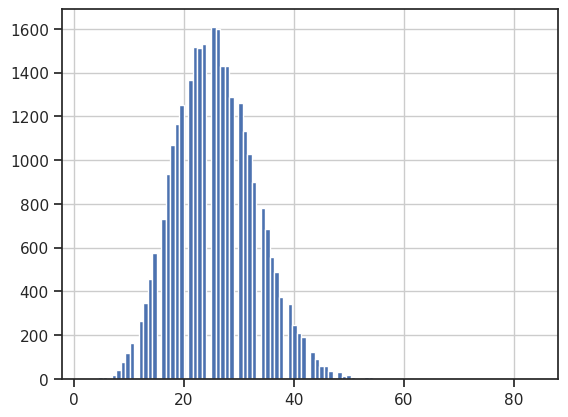

In [ ]:
all_df[(all_df.task == 'GEOM-C') & (all_df.method == 'DDPM')].n_unconstrained_heavy_coords.hist(bins=100)

<AxesSubplot: >

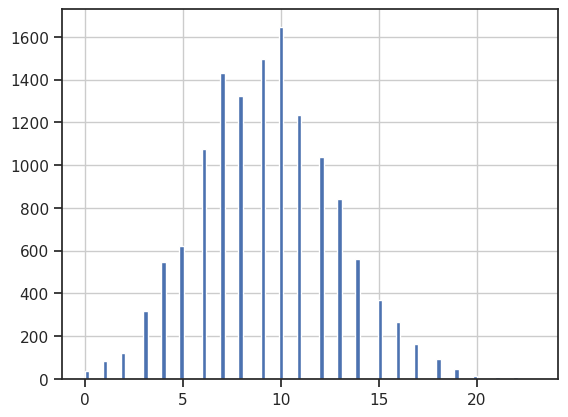

In [ ]:
all_df[(all_df.task == 'QM9-C') & (all_df.method == 'DDPM')].n_unconstrained_heavy_coords.hist(bins=100)

In [11]:
methods = ['GA', 'DDPM']
tasks = ['QM9', 'QM9-C', 'GEOM', 'GEOM-C']
settings = []
list_of_idxs = []
for method in methods:
    for task in tasks:
        settings.append((method, task))
        list_of_idxs.append(all_df.reset_index().index[(all_df.task == task) & (all_df.method == method)].to_list())
len(list_of_idxs)

8

In [12]:
from draw import add, compare_fit
import py3Dmol
n_examples = 10
n_cols = 5
n_rows = 8
width = 250
height = 250
radius = 0.03
color = 'black'

In [19]:
gridview = py3Dmol.view(width=width*n_cols, height=height*n_rows, viewergrid=(n_rows, n_cols))
for a in range(4):
    print(settings[a])

    np.random.seed(2)
    random_examples = np.random.choice(list_of_idxs[a], n_examples, replace=False)
    random_examples = [all_samples[i] for i in random_examples]


    for i in range(n_examples):
        ex = random_examples[i]
        M_pred = ex['preds'][0]
        M_true = ex['true']
        correct = ex['correct'][0]
        heavy_correct = ex['heavy_correct'][0]

        row = (a*n_examples + i) // n_cols
        col = (a*n_examples + i) % n_cols

        gridview = compare_fit(gridview, M_true, M_pred, viewer=(row, col), radius=radius, color=color)
        # name = df.iloc[ood_idxs[i]]["name"]
        # gridview.addLabel(name, {"screenOffset": {"x":10, "y":0}, "useScreen": True, "showBackground": False, "fontColor": "black", "fontSize": 16, "fontFace": "Arial"}, viewer=(row, col))

        if correct:
            bg = "#cffbcf"
        elif heavy_correct:
            bg = "#feefb2"
        else:
            bg = "#f4ccca"
        gridview.setBackgroundColor(bg, viewer=(row, col))
        if a == 2 or a == 3:
            gridview.zoom(0.6, viewer=(row, col))

gridview.show()

('GA', 'QM9')
('GA', 'QM9-C')
('GA', 'GEOM')
('GA', 'GEOM-C')


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [20]:
gridview.render()
t = gridview.js()
js = t.startjs + t.endjs
with open('baseline_samples.html', 'w') as f:
    f.write(js)

In [16]:
gridview = py3Dmol.view(width=width*n_cols, height=height*n_rows, viewergrid=(n_rows, n_cols))
for a in range(4, 8):
    print(settings[a])

    np.random.seed(2)
    random_examples = np.random.choice(list_of_idxs[a], n_examples, replace=False)
    random_examples = [all_samples[i] for i in random_examples]


    for i in range(n_examples):
        ex = random_examples[i]
        M_pred = ex['preds'][0]
        M_true = ex['true']
        correct = ex['correct'][0]
        heavy_correct = ex['heavy_correct'][0]

        row = ((a-4)*n_examples + i) // n_cols
        col = ((a-4)*n_examples + i) % n_cols

        gridview = compare_fit(gridview, M_true, M_pred, viewer=(row, col), radius=radius, color=color)
        # name = df.iloc[ood_idxs[i]]["name"]
        # gridview.addLabel(name, {"screenOffset": {"x":10, "y":0}, "useScreen": True, "showBackground": False, "fontColor": "black", "fontSize": 16, "fontFace": "Arial"}, viewer=(row, col))

        if correct:
            bg = "#cffbcf"
        elif heavy_correct:
            bg = "#feefb2"
        else:
            bg = "#f4ccca"
        gridview.setBackgroundColor(bg, viewer=(row, col))
        if a == 6 or a == 7:
            gridview.zoom(0.6, viewer=(row, col))

gridview.show()

('DDPM', 'QM9')
('DDPM', 'QM9-C')
('DDPM', 'GEOM')
('DDPM', 'GEOM-C')


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [21]:
gridview.render()
t = gridview.js()
js = t.startjs + t.endjs
with open('ddpm_samples.html', 'w') as f:
    f.write(js)